In [1]:
import sys
import os

# Get the absolute path of the current notebook's directory
notebook_dir = os.path.dirname(os.path.abspath("__file__")) # For .py files
# If in a Jupyter notebook, you might need:
# notebook_dir = os.getcwd() # Gets the directory where the notebook is running

# Get the absolute path of the project root (one level up from 'notebooks')
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the project root to sys.path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from typing import Dict, Any, List

In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from src.services import simulate_arrivals

Load the data

In [5]:
sd_data = pd.read_pickle("../data/data_for_queueing_model.pkl")

In [6]:
sd_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30578 entries, 3942 to 29909
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   Orden                      30578 non-null  int64          
 1   Sucursal                   30578 non-null  object         
 2   FechaID                    30578 non-null  datetime64[ns] 
 3   HoraLLegada                30578 non-null  int64          
 4   TurnoID                    30578 non-null  int64          
 5   Turno                      30578 non-null  object         
 6   TurnoTipo                  30578 non-null  object         
 7   TurnoHoraInicio            30578 non-null  object         
 8   TurnoHoraFin               30578 non-null  object         
 9   TurnoMinutosEspera         30578 non-null  float64        
 10  TAPRecepcionMinutos        26316 non-null  float64        
 11  TAPRecepcionCaja           26316 non-null  float64      

In [ ]:
"""
# copy dataframe to perform arrivals simulation
arrivals_simul_df = sd_data.copy()
# Assuming clinics_df is loaded and has 'Sucursal', 'Group', 'TurnoInicioDateTime'
# Extract time features
arrivals_simul_df['Date'] = arrivals_simul_df['TurnoInicioDateTime'].dt.date # For counting unique days of operation

# Calculate the number of unique days each specific (Sucursal, Group, DayOfWeek, Hour) slot was observed
# This is important for averaging correctly.
# First, count how many distinct dates of operation exist for each Sucursal-Group-DayOfWeek-Hour combination.

# To count the number of observation periods for each slot:
# e.g., how many Mondays at 9 AM did we observe for Sucursal A, Group P?
observation_periods = arrivals_simul_df.groupby(
    ['Sucursal', 'Group', 'DayOfWeekName', 'HourOfDay']
)['Date'].nunique().reset_index(name='NumObservationPeriods')

# Calculate total arrivals for each slot
total_arrivals_in_slot = arrivals_simul_df.groupby(
    ['Sucursal', 'Group', 'DayOfWeekName', 'HourOfDay']
).size().reset_index(name='TotalArrivals')

# Merge to calculate average rate
lambda_t_df = pd.merge(
    total_arrivals_in_slot,
    observation_periods,
    on=['Sucursal', 'Group', 'DayOfWeekName', 'HourOfDay']
)

# The rate lambda(t) is arrivals per hour for that slot
lambda_t_df['ArrivalRate_Lambda_t'] = lambda_t_df['TotalArrivals'] / lambda_t_df['NumObservationPeriods']

print("Estimated Piecewise Lambda(t) (Arrivals per Hour for each slot):")
print(lambda_t_df.head())

# You can now sort this for easier lookup or plotting
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
lambda_t_df['DayOfWeekName'] = pd.Categorical(lambda_t_df['DayOfWeekName'], categories=days_order, ordered=True)
lambda_t_df.sort_values(by=['Sucursal', 'Group', 'DayOfWeekName', 'HourOfDay'], inplace=True)
"""

Estimated Piecewise Lambda(t) (Arrivals per Hour for each slot):
   Sucursal Group DayOfWeekName  HourOfDay  TotalArrivals  \
0  CULIACAN    NP        Friday          6            127   
1  CULIACAN    NP        Friday          7            244   
2  CULIACAN    NP        Friday          8            275   
3  CULIACAN    NP        Friday          9            236   
4  CULIACAN    NP        Friday         10            188   

   NumObservationPeriods  ArrivalRate_Lambda_t  
0                      4                 31.75  
1                      4                 61.00  
2                      4                 68.75  
3                      4                 59.00  
4                      4                 47.00  


In [127]:
"""
# Calculate the sum of 'TotalArrivals' grouped by 'Sucursal' and 'DayOfWeekName'
grouped_arrivals = lambda_t_df.groupby(['Sucursal', 'DayOfWeekName'], observed=True)['TotalArrivals'].sum()

# Unstack the 'Sucursal' level to use for grouping bars. 'DayOfWeekName' will be on the x-axis.
# The 'DayOfWeekName' column in lambda_t_df is an ordered categorical type,
# so the x-axis will maintain the correct order of days.
plot_df = grouped_arrivals.unstack(level='Sucursal')

# Create the bar plot
plot_df.plot(kind='bar', figsize=(12, 7), width=0.8)

# Add titles and labels for clarity
plt.title('Total Arrivals by Day of Week and Sucursal')
plt.xlabel('Day of the Week')
plt.ylabel('Total Arrivals')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(title='Sucursal')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid for easier value reading
plt.tight_layout() # Adjust layout to make sure everything fits
plt.show()
"""

"\n# Calculate the sum of 'TotalArrivals' grouped by 'Sucursal' and 'DayOfWeekName'\ngrouped_arrivals = lambda_t_df.groupby(['Sucursal', 'DayOfWeekName'], observed=True)['TotalArrivals'].sum()\n\n# Unstack the 'Sucursal' level to use for grouping bars. 'DayOfWeekName' will be on the x-axis.\n# The 'DayOfWeekName' column in lambda_t_df is an ordered categorical type,\n# so the x-axis will maintain the correct order of days.\nplot_df = grouped_arrivals.unstack(level='Sucursal')\n\n# Create the bar plot\nplot_df.plot(kind='bar', figsize=(12, 7), width=0.8)\n\n# Add titles and labels for clarity\nplt.title('Total Arrivals by Day of Week and Sucursal')\nplt.xlabel('Day of the Week')\nplt.ylabel('Total Arrivals')\nplt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability\nplt.legend(title='Sucursal')\nplt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid for easier value reading\nplt.tight_layout() # Adjust layout to make sure everything fits\nplt.show

La gráfica de arriba muestra que las llegadas no son homogéneas a lo largo de la semana. Según el día de la semana habrá más o menos clientes que atender. Por lo tanto, al simular las llegadas tenemos que tomar en cuenta el día de la semana que sea.

In [128]:
"""
simulated_data_df = simulate_arrivals.run_arrival_simulation(
    full_arrival_rates_df=lambda_t_df,
    sucursal_to_simulate='CULIACAN',
    group_to_simulate='NP',
    sim_start_datetime_str='2025-05-12 00:00:00',
    sim_duration_days=28
)
"""

"\nsimulated_data_df = simulate_arrivals.run_arrival_simulation(\n    full_arrival_rates_df=lambda_t_df,\n    sucursal_to_simulate='CULIACAN',\n    group_to_simulate='NP',\n    sim_start_datetime_str='2025-05-12 00:00:00',\n    sim_duration_days=28\n)\n"

In [9]:
sd_data.groupby(['Sucursal', 'Group'])['TimeInService_minutes'].mean()

Sucursal                  Group
CULIACAN                  NP       4.156160
                          P        3.328669
CULIACAN CAÑADAS          NP       3.177492
                          P        2.142804
CULIACAN COLEGIO MILITAR  NP       3.448537
                          P        2.539955
CULIACAN LA CONQUISTA     NP       2.885149
                          P        1.765234
Name: TimeInService_minutes, dtype: float64

## Real data

In [7]:
# Global variables
SUCURSAL = 'CULIACAN COLEGIO MILITAR'
NP_GROUP = 'NP'
P_GROUPS = {'P'}
CHOSEN_DATE = '2024-03-01'
TIME_LIMIT_THRESHOLD = 10
P_THRESHOLD = 5
OPENING_TIME = 6
CLOSING_TIME = 19

In [8]:
sd_data.columns

Index(['Orden', 'Sucursal', 'FechaID', 'HoraLLegada', 'TurnoID', 'Turno',
       'TurnoTipo', 'TurnoHoraInicio', 'TurnoHoraFin', 'TurnoMinutosEspera',
       'TAPRecepcionMinutos', 'TAPRecepcionCaja', 'TurnoInicioDateTime',
       'TurnoFinDateTime', 'TurnoGrupo', 'WaitingTimeInLine', 'HourOfDay',
       'TimeInService', 'HasTimeInService', 'TimeInService_seconds',
       'TimeInService_minutes', 'WaitingTimeInLine_seconds',
       'WaitingTimeInLine_minutes', 'DayOfWeek', 'DayOfWeekName',
       'InterArrivalTimedelta', 'InterArrivalMinutes', 'TimeBin', 'Group'],
      dtype='object')

In [9]:
columns = [
    'Sucursal', 
    'FechaID', 
    'TurnoInicioDateTime',
    'TurnoFinDateTime',
    'Group',
    'TurnoGrupo',
    'WaitingTimeInLine_minutes',
    'TimeInService_minutes',
    'TAPRecepcionCaja'
]
chosen_sucursal_n_date_data = sd_data[
    (sd_data['Sucursal'] == SUCURSAL) & (sd_data['FechaID'] == CHOSEN_DATE)
]
real_data_one_day = chosen_sucursal_n_date_data[columns]
real_data_one_day.head()

,Sucursal,FechaID,TurnoInicioDateTime,TurnoFinDateTime,Group,TurnoGrupo,WaitingTimeInLine_minutes,TimeInService_minutes,TAPRecepcionCaja
27069,CULIACAN COLEGIO MILITAR,2024-03-01,2024-03-01 06:29:25,2024-03-01 06:30:04,P,P,0.650000,4.40,3758.0
27709,CULIACAN COLEGIO MILITAR,2024-03-01,2024-03-01 06:29:38,2024-03-01 06:34:29,NP,N,4.850000,3.70,3758.0
28983,CULIACAN COLEGIO MILITAR,2024-03-01,2024-03-01 06:29:53,2024-03-01 06:38:11,NP,N,8.300000,5.23,3758.0
28348,CULIACAN COLEGIO MILITAR,2024-03-01,2024-03-01 06:30:04,2024-03-01 06:38:46,NP,N,8.700000,4.02,3687.0
19417,CULIACAN COLEGIO MILITAR,2024-03-01,2024-03-01 06:30:16,2024-03-01 06:42:47,NP,N,12.516667,4.33,3687.0


45.03105590062112 % of customers waited more than 10


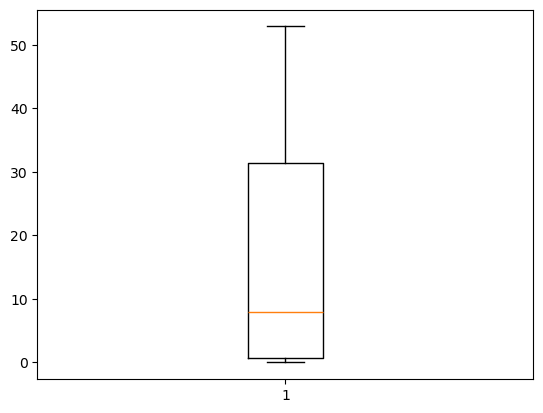

In [10]:
percentage_above_threshold = (
    real_data_one_day['WaitingTimeInLine_minutes'] > TIME_LIMIT_THRESHOLD
).sum() / real_data_one_day.shape[0] * 100
print(f'{percentage_above_threshold} % of customers waited more than {TIME_LIMIT_THRESHOLD}')
plt.boxplot(real_data_one_day['WaitingTimeInLine_minutes'])
plt.show()

In [11]:
real_data_one_day.groupby(
    'Group'
)['WaitingTimeInLine_minutes'].apply(
    lambda x: print(
        f'{x.name} customers with waiting time more than {TIME_LIMIT_THRESHOLD} minutes: {(x > TIME_LIMIT_THRESHOLD).sum() / real_data_one_day.shape[0] * 100} %')
)
!

NP customers with waiting time more than 10 minutes: 44.72049689440994 %
P customers with waiting time more than 10 minutes: 0.3105590062111801 %


In [12]:
real_data_one_day.groupby(
    'Group'
)['WaitingTimeInLine_minutes'].apply(
    lambda x: print(
        f'{x.name} mean waiting time: {x.mean()} minutes')
)
!

NP mean waiting time: 18.203459119496852 minutes
P mean waiting time: 2.4114035087719294 minutes


In [13]:
real_data_one_day.shape

(322, 9)

In [14]:
real_data_one_day.groupby('TurnoGrupo')['WaitingTimeInLine_minutes'].mean()

TurnoGrupo
C     2.205769
F     0.620833
N    20.612987
P     2.411404
Name: WaitingTimeInLine_minutes, dtype: float64

In [15]:
real_data_one_day[real_data_one_day['TurnoGrupo'] == 'F']['WaitingTimeInLine_minutes']

25812    0.783333
21343    1.000000
27078    1.500000
28993    0.216667
23243    0.083333
27083    1.216667
28362    0.083333
27088    0.083333
Name: WaitingTimeInLine_minutes, dtype: float64

In [16]:
real_data_one_day['TurnoGrupo'].value_counts()

TurnoGrupo
N    231
P     57
C     26
F      8
Name: count, dtype: int64

In [17]:
from src.external_systems.dataframe_repo import DataFrameRepo

In [18]:
# more info related to this specific branch
number_of_windows = len(real_data_one_day['TAPRecepcionCaja'].dropna().unique())
print("Number of windows:", number_of_windows)
# Setup service times based on real data analysis
service_times = real_data_one_day.groupby('TurnoGrupo')['TimeInService_minutes'].mean().to_dict()
service_data = {
    "ticket_type": ["C", "F", 'N', 'P'],
    "service_time": [
        service_times["C"], service_times["F"], service_times['N'], service_times['P']
    ],  # Average from real data
}
service_times_df = pd.DataFrame(service_data)
service_times_repo = DataFrameRepo(data=service_times_df)

Number of windows: 3


In [19]:
service_times_df

,ticket_type,service_time
0,C,3.688400
1,F,3.193750
2,N,2.907105
3,P,2.457593


In [74]:
real_data_one_day['customer_id'] = list(range(0, real_data_one_day.shape[0]))

C:\Users\cumpl\AppData\Local\Temp\ipykernel_14636\929453559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_one_day['customer_id'] = list(range(0, real_data_one_day.shape[0]))


## Results with our system

In [21]:
from datetime import datetime, timedelta

from typing import List

from src.entities.customer import Customer
from src.entities.service_window import ServiceWindow
from src.external_systems.priority_queue_leo import PriorityQueueLeo
from src.services.manipulate_queue import update_queue_improved

import pandas as pd

In [22]:
real_data_one_day.head(1)

,Sucursal,FechaID,TurnoInicioDateTime,TurnoFinDateTime,Group,TurnoGrupo,WaitingTimeInLine_minutes,TimeInService_minutes,TAPRecepcionCaja
27069,CULIACAN COLEGIO MILITAR,2024-03-01,2024-03-01 06:29:25,2024-03-01 06:30:04,P,P,0.65,4.4,3758.0


In [102]:
list_of_customers: List[Customer] = []
for row, arrival in real_data_one_day.iterrows():
    arrival_time, group = (
        real_data_one_day.loc[row, "TurnoInicioDateTime"], 
        real_data_one_day.loc[row, "TurnoGrupo"]
    )
    customer_id = real_data_one_day.loc[row, "customer_id"]
    list_of_customers.append(
        Customer(
            customer_id,
            arrival_time,
            group,            
        )
    )
len(list_of_customers)

322

In [103]:
list_of_customers[-1].arrival_time

Timestamp('2024-03-01 18:34:12')

**Initialize queueu**

In [104]:
priority_queue = PriorityQueueLeo([])

**Initialize windows** (static approach)

In [105]:
service_points: List[ServiceWindow] = [
    ServiceWindow(i) for i in range(number_of_windows)
]

**Variables**

In [ ]:
MAX_JUMPS_P = 2
JUMPS_LIMIT = 5

**Simulate queueing system**

In [107]:
pd.to_datetime(CHOSEN_DATE) + timedelta(hours = CLOSING_TIME)

Timestamp('2024-03-01 19:00:00')

In [ ]:
closing_datetime = pd.to_datetime(CHOSEN_DATE) + timedelta(hours = CLOSING_TIME)
current_time = pd.to_datetime(CHOSEN_DATE) + timedelta(hours=OPENING_TIME)

In [109]:
def get_simulated_waiting_times(
        current_time, 
        closing_datetime, 
        list_of_customers, 
        priority_queue, 
        service_points,
        service_times_repo: DataFrameRepo,
        P_GROUPS: set,
        P_THRESHOLD: int,
        TIME_LIMIT_THRESHOLD: int,
        MAX_JUMPS_P: int,
        JUMPS_LIMIT: int,
        debug: bool = False,
):
    customers_to_arrive = len(list_of_customers)
    last_customer = 0
    customers_time_in_line = list()
    number_of_windows = len(service_points)
    while current_time < closing_datetime and last_customer < customers_to_arrive:
        
        current_customer = list_of_customers[last_customer]

        # actualizamos los puntos de servicio (las ventanillas)
        for window in service_points:
            if window.is_service_complete(current_time):
                window.finish_service()
                
        # checamos si ya sucedió un evento de llegada
        if current_customer.arrival_time <= current_time:
            # formamos al cliente
            priority_queue.enqueue(current_customer)
            last_customer += 1
            # esto es un evento del cual tenemos un timestamp
            # esto lo utilizamos para hacer trigger del proceso de actualización de la fila
            customer_arrival_time = current_customer.arrival_time
            priority_queue = update_queue_improved(
                queue=priority_queue,
                service_times_repo=service_times_repo,
                service_points=number_of_windows,
                priority_tickets=P_GROUPS,
                p_threshold=P_THRESHOLD,
                non_p_threshold=TIME_LIMIT_THRESHOLD,
                current_time=customer_arrival_time,
                max_jumps_p=MAX_JUMPS_P,
                jumps_limit=JUMPS_LIMIT,
            )

        # checamos si hay alguien en la fila
        if len(priority_queue) > 0: 
            # ahora checamos si el cliente más adelante en la fila puede ser atendido
            window_available = False
            window_available_id = None
            for window in service_points:
                if window.is_available:
                    window_available = True
                    window_available_id = window.window_id
                    break
            if window_available:
                # get customer out of queue
                customer_to_attend = priority_queue.dequeue()
                total_time_in_queue = current_time - customer_to_attend.arrival_time
                customers_time_in_line.append(total_time_in_queue)
                if debug:
                    print(f'Current time: {current_time}')
                    print(f'Attending customer {customer_to_attend.customer_id} ({customer_to_attend.ticket_type}), time in line: {total_time_in_queue}') # here I can get the total waiting time in line
                # update status of available window
                service_points[window_available_id].start_service(
                    customer=customer_to_attend,
                    service_end_time=current_time + timedelta(
                        minutes=service_times_repo.get_data(
                            {'ticket_type': customer_to_attend.ticket_type}
                        ).iloc[0, 1]
                    )
                )
            else:
                #print("Current time:", current_time)
                #print("No windows available")
                # priority_queue.print_queue(current_time)
                pass
        
        
        current_time = current_time + timedelta(seconds=1)
    return customers_time_in_line

In [110]:
get_simulated_waiting_times(
    current_time=current_time, 
    closing_datetime=closing_datetime, 
    list_of_customers=list_of_customers, 
    priority_queue=priority_queue, 
    service_points=service_points,
    service_times_repo=service_times_repo,
    P_GROUPS=P_GROUPS,
    P_THRESHOLD=P_THRESHOLD,
    TIME_LIMIT_THRESHOLD=TIME_LIMIT_THRESHOLD,
    MAX_JUMPS_P=MAX_JUMPS_P,
    JUMPS_LIMIT=JUMPS_LIMIT
)

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:01:49'),
 Timedelta('0 days 00:02:17'),
 Timedelta('0 days 00:02:21'),
 Timedelta('0 days 00:04:11'),
 Timedelta('0 days 00:02:06'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:02:37'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:08'),
 Timedelta('0 days 00:00:08'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:01:43'),
 Timedelta('0 days 00:02:42'),
 Timedelta('0 days 00:01:23'),
 Timedelta('0 days 00:03:06'),
 Timedelta('0 days 00:03:24'),
 Timedelta('0 days 00:00:33'),
 Timedelta('0 days 00:01:37'),
 Timedelta('0 days 00:00:49'),
 Timedel

In [84]:
customers_time_in_line_minutes = [time_line.total_seconds() / 60 for time_line in customers_time_in_line]

In [86]:
real_data_one_day['simulated_waiting_time_minutes'] = customers_time_in_line_minutes

C:\Users\cumpl\AppData\Local\Temp\ipykernel_14636\376662386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_one_day['simulated_waiting_time_minutes'] = customers_time_in_line_minutes


In [90]:
real_data_one_day.groupby('TurnoGrupo')[['WaitingTimeInLine_minutes', 'simulated_waiting_time_minutes']].mean().to_dict()

{'WaitingTimeInLine_minutes': {'C': 2.205769230769231,
  'F': 0.6208333333333333,
  'N': 20.612987012987016,
  'P': 2.4114035087719294},
 'simulated_waiting_time_minutes': {'C': 0.6698717948717949,
  'F': 0.5770833333333333,
  'N': 1.3883838383838383,
  'P': 1.1883040935672515}}

# Run system analysis

In [125]:
def get_real_data(
    sucursal: str, 
    fecha_id: str, 
    sd_data: pd.DataFrame,
    columns: List[str],
) -> pd.DataFrame:
    return sd_data[
        (sd_data['Sucursal'] == sucursal) & (sd_data['FechaID'] == fecha_id)
    ][columns].copy()


def get_opening_and_closing_times(
    df: pd.DataFrame,
    column: str,
):
    min_time = df[column].min()
    max_time = df[column].max()
    # Round down for opening time, round up for closing time
    opening_time = min_time.replace(minute=0, second=0, microsecond=0)
    closing_time = max_time.replace(minute=0, second=0, microsecond=0)
    if max_time.minute > 0 or max_time.second > 0 or max_time.microsecond > 0:
        closing_time = closing_time + pd.Timedelta(hours=1)
        
    return opening_time.hour, closing_time.hour


def build_list_of_customers(df: pd.DataFrame) -> List[Customer]:
    list_of_customers: List[Customer] = []
    for row, arrival in df.iterrows():
        arrival_time, group = (
            df.loc[row, "TurnoInicioDateTime"], 
            df.loc[row, "TurnoGrupo"]
        )
        customer_id = df.loc[row, "customer_id"]
        list_of_customers.append(
            Customer(
                customer_id,
                arrival_time,
                group,            
            )
        )
    return list_of_customers


def get_number_of_windows(df: pd.DataFrame, column) -> int:
    """Get the number of unique service windows from the DataFrame."""
    return len(df[column].dropna().unique())


def build_service_times_repo(
    df: pd.DataFrame,
    ticket_types: List[str],
) -> DataFrameRepo:
    """Build a DataFrameRepo for service times based on the provided DataFrame."""
    service_times = df.groupby('TurnoGrupo')['TimeInService_minutes'].mean().to_dict()
    service_data = {
        "ticket_type": sorted(ticket_types),
        "service_time": [
            service_times[ticket] for ticket in sorted(ticket_types)
        ],  # Average from real data
    }
    service_times_df = pd.DataFrame(service_data)
    return DataFrameRepo(data=service_times_df)


def get_waiting_time_of_non_attended_customers(ix, list_of_customers: List[Customer], closing_datetime: pd.Timestamp):
    """Calculate the waiting time of non-attended customers."""
    return [
        closing_datetime - customer.arrival_time for customer in list_of_customers[ix:]
    ]


results_dict = {}
P_GROUPS = {'P'}
TIME_LIMIT_THRESHOLD = 20
P_THRESHOLD = 7
MAX_JUMPS_P = 2
JUMPS_LIMIT = 5

for sucursal in sd_data['Sucursal'].unique():
    results_dict[sucursal] = {}
    print(f"\n\nProcessing Sucursal: {sucursal}\n\n")
    possible_dates = sd_data[sd_data['Sucursal'] == sucursal]['FechaID'].unique()
    for date in possible_dates:
        results_dict[sucursal][date] = {}
        real_data = get_real_data(
            sucursal=sucursal, 
            fecha_id=date, 
            sd_data=sd_data,
            columns=columns
        )
        if real_data.empty:
            print(f"No data for {sucursal} on {date}")
            continue
        opening_time, closing_time = get_opening_and_closing_times(
            df=real_data, 
            column='TurnoInicioDateTime'
        )
        print(f"Sucursal: {sucursal}, Date: {date}, Opening Time: {opening_time}, Closing Time: {closing_time}")
        real_data['customer_id'] = list(range(0, real_data.shape[0]))
        list_of_customers = build_list_of_customers(real_data)
        print(f"Number of customers to simulate: {len(list_of_customers)}")
        priority_queue = PriorityQueueLeo([])
        number_of_windows = get_number_of_windows(real_data, 'TAPRecepcionCaja')
        service_points: List[ServiceWindow] = [
            ServiceWindow(i) for i in range(number_of_windows)
        ]
        service_times_repo = build_service_times_repo(real_data, real_data['TurnoGrupo'].dropna().unique().tolist())
        customers_time_in_line = get_simulated_waiting_times(
            current_time=pd.to_datetime(date) + timedelta(hours=opening_time), 
            closing_datetime=pd.to_datetime(date) + timedelta(hours=closing_time), 
            list_of_customers=list_of_customers, 
            priority_queue=priority_queue, 
            service_points=service_points,
            service_times_repo=service_times_repo,
            P_GROUPS=P_GROUPS,
            P_THRESHOLD=P_THRESHOLD,
            TIME_LIMIT_THRESHOLD=TIME_LIMIT_THRESHOLD,
            MAX_JUMPS_P=MAX_JUMPS_P,
            JUMPS_LIMIT=JUMPS_LIMIT
        )
        customers_time_in_line_minutes = [time_line.total_seconds() / 60 for time_line in customers_time_in_line]
        print(f"Number of customers processed: {len(customers_time_in_line_minutes)}")
        if len(customers_time_in_line_minutes) < real_data.shape[0]:
            print(f"Not all customers were attended")
            non_attended_waiting_times = get_waiting_time_of_non_attended_customers(
                ix=len(customers_time_in_line_minutes), 
                list_of_customers=list_of_customers, 
                closing_datetime=pd.to_datetime(date) + timedelta(hours=closing_time)
            )
            customers_time_in_line_minutes.extend(
                [time.total_seconds() / 60 for time in non_attended_waiting_times]
            )
            print(f"Added waiting times for non-attended customers: {len(non_attended_waiting_times)}")

        data_with_results = real_data.copy()
        data_with_results['simulated_waiting_time_minutes'] = customers_time_in_line_minutes
        results = data_with_results.groupby(
            'TurnoGrupo'
        )[
            [
                'WaitingTimeInLine_minutes', 
                'simulated_waiting_time_minutes'
            ]
        ].mean().to_dict()
        results_dict[sucursal][date] = results



Processing Sucursal: CULIACAN


Sucursal: CULIACAN, Date: 2024-03-01 00:00:00, Opening Time: 6, Closing Time: 19
Number of customers to simulate: 576
Number of customers processed: 576
Sucursal: CULIACAN, Date: 2024-03-02 00:00:00, Opening Time: 5, Closing Time: 17
Number of customers to simulate: 466
Number of customers processed: 466
Sucursal: CULIACAN, Date: 2024-03-03 00:00:00, Opening Time: 6, Closing Time: 14
Number of customers to simulate: 285
Number of customers processed: 285
Sucursal: CULIACAN, Date: 2024-03-04 00:00:00, Opening Time: 6, Closing Time: 19
Number of customers to simulate: 599
Number of customers processed: 599
Sucursal: CULIACAN, Date: 2024-03-05 00:00:00, Opening Time: 6, Closing Time: 19
Number of customers to simulate: 604
Number of customers processed: 604
Sucursal: CULIACAN, Date: 2024-03-06 00:00:00, Opening Time: 6, Closing Time: 19
Number of customers to simulate: 574
Number of customers processed: 574
Sucursal: CULIACAN, Date: 2024-03-07 00:00:00, O